In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
import imageio
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import name_best_ckpt, generate_Beta_epoch, make_h_combined, same_stim_trial
from tools_lnd import get_T_inds, gen_trials_from_model_dir

PATH_TO_RECURRENT_WHISPERER = p+'/code/recurrent-whisperer'#'/home/laura/code/recurrent-whisperer'#
sys.path.insert(0, PATH_TO_RECURRENT_WHISPERER)
from RecurrentWhisperer import RecurrentWhisperer

PATH_TO_FIXED_POINT_FINDER = p+'/code/fixed-point-finder' #'/home/laura/code/fixed-point-finder-experimental'#
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
from FixedPointFinder import FixedPointFinder

No display found. Using non-interactive Agg backend.


/Users/lauradriscoll/Documents/code/recurrent-whisperer/AdaptiveLearningRate.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance


In [8]:
net = 'stepnet'
rule = 'delaygo'
fp_epoch = 'go1'
model_n = 0
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0'
# dir_specific_all = net+'/crystals/softplus/l2w0001'#'crystals_no_noise/softplus/l2w0001/'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/#'lowD/grad_norm_l2001/most/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
# model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
model_dir_all = m

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt


In [9]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0_cat(params, x_t, h0, alpha):
    h = h0
    h_t = h0
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t = np.concatenate((h_t,h[np.newaxis,:]),axis = 0)

    return h_t

In [10]:
from tools_lnd import gen_trials_from_model_dir,same_stim_trial
trial_target = gen_trials_from_model_dir(model_dir_all,'delayanti',noise_on = False)

rule_set_nums = [2,3,0]
rule_set_ttls = [rules_dict['all'][rule_set_nums[0]],rules_dict['all'][rule_set_nums[1]],
                 rules_dict['all'][rule_set_nums[2]],'composite a+b-c']

trial1 = gen_trials_from_model_dir(model_dir_all,rule_set_ttls[0],noise_on = False)

trial_master2 = gen_trials_from_model_dir(model_dir_all,rule_set_ttls[0],noise_on = False)
trial2 =  same_stim_trial(trial_master2,rule_set_nums[1])
trial2.x[trial2.epochs['stim1'][0]:,:,1:5] = trial2.x[trial2.epochs['stim1'][0],:,1:5]

trial_master3 = gen_trials_from_model_dir(model_dir_all,rule_set_ttls[0],noise_on = False)
trial3 = same_stim_trial(trial_master3,rule_set_nums[2])
trial3.x[trial3.epochs['stim1'][0]:,:,1:5] = trial3.x[trial3.epochs['stim1'][0],:,1:5]

N = n_rnn
T = np.shape(trial1.x)[0]
n_trials = np.shape(trial1.x)[1]
n_inputs = np.shape(trial1.x)[2]
y_set = np.zeros((4,T,80,np.shape(w_out)[1]))

for trial_n in range(0,n_trials):
    t_set = range(trial_n,trial_n+1)

    trail_mix = (trial1.x[:,t_set,:]+trial2.x[:,t_set,:]-trial3.x[:,t_set,:])/3
    
    trial_set = [trial1.x[:,t_set,:],trial2.x[:,t_set,:],trial3.x[:,t_set,:],trail_mix[:,np.newaxis,:]]

    for trial,ind in zip(trial_set,range(len(trial_set))):
        x_t = trial[1:,:1,:]
        h0 = np.zeros(np.shape(h_tf[:1,0,:]))
        h_t = vanilla_run_with_h0_cat(params, x_t, h0, alpha)

        y = np.dot(h_t, w_out) + b_out
        y_set[ind,:,trial_n,:] = y
        
from network import get_perf
perf = np.zeros(len(trial_set))
trial_set = [trial1,trial_target,trial3,trial_target]
for trial,ind in zip(trial_set,range(len(trial_set))):
    perf[ind] = np.mean(get_perf(y_set[ind,:,:,:],trial.y_loc))
print(perf)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multit

In [11]:
def run_network_replacerule(model_dir, rule, replace_rule, rule_strength):
    """Run the network but with replaced rule input weights.

    Args:
        model_dir: model directory
        rule: the rule to test on
        replace_rule: a list of rule input units to use
        rule_strength: the relative strength of each replace rule unit
    """
    model = Model(model_dir)
    hp = model.hp
    with tf.Session() as sess:
        model.restore()

        # Get performance
        batch_size_test = 1000
        n_rep = 20
        batch_size_test_rep = int(batch_size_test/n_rep)
        perf_rep = list()
        for i_rep in range(n_rep):
            trial = generate_trials(rule, hp, 'random', batch_size=batch_size_test_rep,
                                     replace_rule=replace_rule, rule_strength=rule_strength,delay_fac=hp['delay_fac'])
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            y_hat_test = sess.run(model.y_hat, feed_dict=feed_dict)

            perf_rep.append(np.mean(get_perf(y_hat_test, trial.y_loc)))

    return np.mean(perf_rep), rule_strength

def replace_rule_name(replace_rule, rule_strength):
    """Helper function to replace rule name"""
    # little helper function
    name = ''
    counter = 0
    for r, b in zip(replace_rule, rule_strength):
        if b != 0:

            if b == 1:
                if counter==0:
                    prefix = ''
                else:
                    prefix = '+'
            elif b == -1:
                prefix = '-'
            else:
                prefix = '{:+d}'.format(b)
            name += prefix + rule_name[r] + '\n'
            counter += 1
    # get rid of the last \n
    name = name[:-1]
    return name


In [21]:
rule = 'delayanti'
rule = 'delayanti'
replace_rule = np.array(['delayanti', 'fdanti', 'delaygo', 'fdgo'])

rule_strengths = \
    [[1,0,0,0],
     [0,1,0,0],
     [0,1,1,0],
     [0,1,1,-1]]

In [22]:
from network import get_perf
perfs = list()
names = list()
for rule_strength in rule_strengths:
    perf, _ = run_network_replacerule(model_dir_all, rule, replace_rule, rule_strength)
    perfs.append(perf)
    names.append(replace_rule_name(replace_rule, rule_strength))

perfs = np.array(perfs)
print(perfs)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multit

In [32]:
def compute_replacerule_performance(model_dir, setup, restore=False):
    """Compute the performance of one task given a replaced rule input."""

    if setup == 1:
        rule = 'delayanti'
        replace_rule = np.array(['delayanti', 'fdanti', 'delaygo', 'fdgo'])

        rule_strengths = \
            [[1,0,0,0],
             [0,1,0,0],
             [0,1,1,0],
             [0,1,1,-1]]

    elif setup == 2:
        rule = 'contextdelaydm1'
        replace_rule = np.array(['contextdelaydm1', 'contextdelaydm2',
                                 'contextdm1', 'contextdm2'])

        rule_strengths = \
            [[1,0,0,0],
             [0,1,0,0],
             [0,1,1,0],
             [0,0,1,0],
             [0,1,1,-1]]

    elif setup == 3:
        rule = 'dmsgo'
        replace_rule = np.array(['dmsgo', 'dmcgo', 'dmsnogo', 'dmcnogo'])
        rule_strengths = \
            [[1,0,0,0],
             [0,1,0,0],
             [0,1,1,0],
             [0,1,1,-1]]

    else:
        raise ValueError('Unknown setup value')

    perfs = list()
    names = list()
    for rule_strength in rule_strengths:
        perf, _ = run_network_replacerule(model_dir, rule, replace_rule, rule_strength)
        perfs.append(perf)
        names.append(replace_rule_name(replace_rule, rule_strength))

    perfs = np.array(perfs)
    print(names)
    print(perfs)

    return perfs, rule, names

def run_network_replacerule(model_dir, rule, replace_rule, rule_strength):
    """Run the network but with replaced rule input weights.

    Args:
        model_dir: model directory
        rule: the rule to test on
        replace_rule: a list of rule input units to use
        rule_strength: the relative strength of each replace rule unit
    """
    model = Model(model_dir)
    hp = model.hp
    with tf.Session() as sess:
        model.restore()

        # Get performance
        batch_size_test = 1000
        n_rep = 20
        batch_size_test_rep = int(batch_size_test/n_rep)
        perf_rep = list()
        for i_rep in range(n_rep):
            trial = generate_trials(rule, hp, 'random', batch_size=batch_size_test_rep,noise_on=True,
                                     replace_rule=replace_rule, rule_strength=rule_strength,delay_fac=hp['delay_fac'])
            
#             plt.plot(trial.x[0,:,5:].T,'.')
            
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            y_hat_test = sess.run(model.y_hat, feed_dict=feed_dict)

            perf_rep.append(np.mean(get_perf(y_hat_test, trial.y_loc)))
            
#         plt.show()

    return np.mean(perf_rep), rule_strength

def replace_rule_name(replace_rule, rule_strength):
    """Helper function to replace rule name"""
    # little helper function
    name = ''
    counter = 0
    for r, b in zip(replace_rule, rule_strength):
        if b != 0:

            if b == 1:
                if counter==0:
                    prefix = ''
                else:
                    prefix = '+'
            elif b == -1:
                prefix = '-'
            else:
                prefix = '{:+d}'.format(b)
            name += prefix + rule_name[r] + '\n'
            counter += 1
    # get rid of the last \n
    name = name[:-1]
    return name


In [35]:
p

'/Users/lauradriscoll/Documents'

In [36]:
os.path.join(p,'data/rnn/multitask/crystals_no_noise/softplus/l2w0001',str(model_n))

'/Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multit

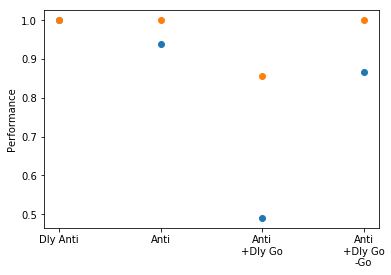

In [37]:
#this is robert's code for the analysis, performance and names printed
for model_n in [0,1]:
    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals_no_noise/softplus/l2w0001',str(model_n))
    perfs, rule, names = compute_replacerule_performance(model_dir_all, setup=1)
    plt.plot(perfs,'o')
    plt.xticks(range(len(names)),names)
    plt.ylabel('Performance')
plt.show()

In [25]:
###SECTION ON CALCULATING SHARED VARIANCE ACROSS TASKS

trial = {}
h = {}
model = Model(model_dir_all)
with tf.Session() as sess:

    model.restore()#model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hp = model.hp

    for rule in hp['rule_trains']:
        trial[rule] = generate_trials(rule, hp, 'random',
                        batch_size=400, delay_fac=hp['delay_fac'],noise_on = False)

        # Generating feed_dict.
        feed_dict = tools.gen_feed_dict(model, trial[rule], hp)
        h[rule] = sess.run(model.h, feed_dict=feed_dict)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals_no_noise/softplus/l2w0001/0/model.ckpt


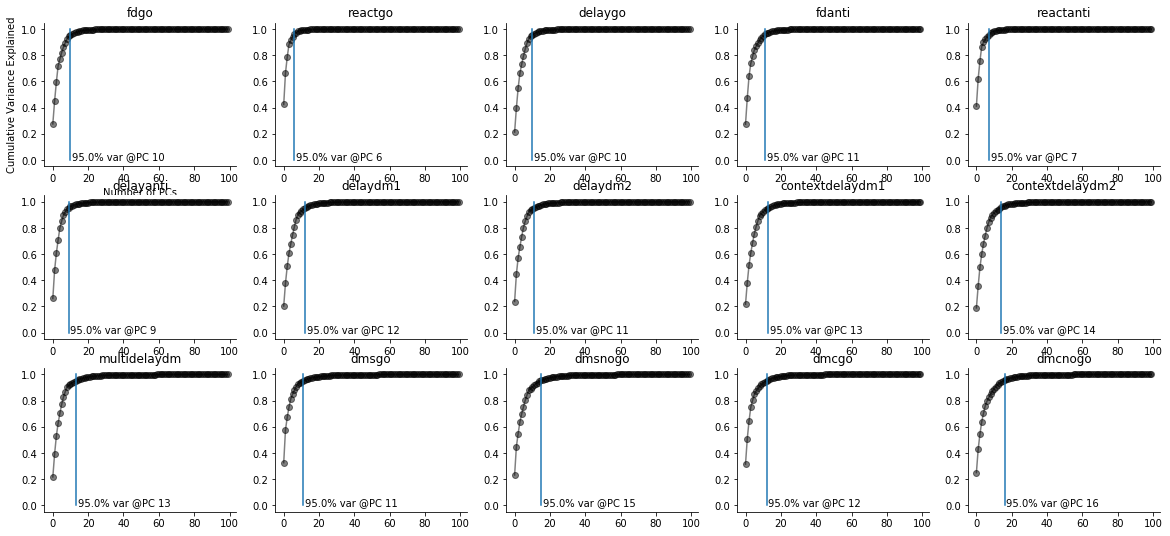

In [29]:
task_list = hparams['rule_trains']
PCS = {}
npcs_rule = {}
nc = np.ceil(len(task_list)/3)
nr = 3
fig = plt.figure(figsize=(4*nc, 3*nr))

for ri in range(len(task_list)):
    rule = task_list[ri]

    ax = plt.subplot(nr,nc,ri+1) 
    pca = PCA(n_components = 100)
    X = np.reshape(h[rule],(-1,N))
    _ = pca.fit_transform(X)
    PCS[rule] = pca.components_
    
    var_lim = .95
    frac_ev = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)
    npcs_rule[rule] = np.argmax(frac_ev>var_lim)+1
    
    plt.plot(frac_ev,'o-k',alpha = .5)
    plt.plot([np.argmax(frac_ev>var_lim),np.argmax(frac_ev>var_lim)],[0,1])
    plt.text(np.argmax(frac_ev>var_lim)+1,0,str(var_lim*100)+'% var @PC '+str(np.argmax(frac_ev>var_lim)))

    plt.title(rule)
    if ri==0:
        plt.ylabel('Cumulative Variance Explained')
        plt.xlabel('Number of PCs')
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()